In [1]:
import os
os.chdir('../')
from helpers import *

mousenums:  ['230', '355', '358', '362', '673', '674', '816', '825']


In [2]:
from scipy.stats import zscore

In [3]:
foldnames = getfoldnames('../')
mousenums = getmousenums('../')
print(mousenums)

['230', '355', '358', '362', '673', '674', '816', '825']


In [4]:
# data is df/f data, and o1, o2, c1, and c2 are the time indices in each arm (open and closed)
# method 2
def celltype(data, o1, o2, c1, c2):
    o =np.hstack((o1, o2))
    c = np.hstack((c1, c2))
    r_c1o1 = ranksums(data[c1], data[o1])
    r_c1o2 = ranksums(data[c1], data[o2])
    r_c2o1 = ranksums(data[c2], data[o1])
    r_c2o2 = ranksums(data[c2], data[o2])
    if r_c1o1[0] < 0 and r_c1o1[1] < 0.05 and r_c1o2[0] < 0 and r_c1o2[1] < 0.05:
        if r_c2o1[0] < 0 and r_c2o1[1] < 0.05 and r_c2o2[0] < 0 and r_c2o2[1] < 0.05:
            return 'o'
    if r_c1o1[0] > 0 and r_c1o1[1] < 0.05 and r_c1o2[0] > 0 and r_c1o2[1] < 0.05:
        if r_c2o1[0] > 0 and r_c2o1[1] < 0.05 and r_c2o2[0] > 0 and r_c2o2[1] < 0.05:
            return 'c'
    return 'n'

In [5]:
def epmscore(data, o1, o2, c1, c2):
    data = zscore(data)
    Fo1 = np.mean(data[o1])
    Fo2 = np.mean(data[o2])
    Fc1 = np.mean(data[c1])
    Fc2 = np.mean(data[c2])
    
    A = 0.25*(np.abs(Fo1 - Fc1) + np.abs(Fo1 - Fc2) + np.abs(Fo2 - Fc1) + np.abs(Fo2 - Fc2))
    B = 0.5*(np.abs(Fo1 - Fo2) + np.abs(Fc1 - Fc2))
    return (A - B)/(A + B)

In [6]:
rat1Ind = {'230': 3, '355': 2, '358': None, '362': 2, '673': 2, '674': 2, '816': 3, '825': 3}
shockInd = {'230': 5, '355': 5, '358': 5, '362': 5, '673': 5, '674': 5, '816': 5, '825': 5}
rat2Ind = {'230': 9, '355': 3, '358': 3, '362': 3, '673': 3, '674': 3, '816': None, '825': None}
epmInd = {'230': 1, '355': 1, '358': 1, '362': 1, '673': 1, '674': 1, '816': 1, '825': 1}
shockExtInd = {'230': 6, '355': 6, '358': 6, '362': 6, '673': None, '674': None, '816': 6, '825': 6}
toyRatInd = {'230': 2, '355': 7, '358': 7, '362': None, '673': 6, '674': 6, '816': 2, '825': 2}
shockHabInd = {'230': 4, '355': 8, '358': 8, '362': 8, '673': 7, '674': 7, '816': 7, '825': None}

outliersEPM = {'230': 3, '355': 2, '358': 3, '362': 1, '673': 3, '674': 2, '816': 7, '825': 4}
outliersRat1 = {'230': 5, '355': 2, '358': None, '362': 1, '673': 0, '674': 0, '816': 5, '825': 0}
outliersShock = {'230': 3, '355': 2, '358': 2, '362': 1, '673': 1, '674': 1, '816': 1, '825': 5}
outliersRat2 = {'230': 4, '355': 0, '358': 1, '362': 1, '673': 2, '674': 1, '816': None, '825': None}
outliersShockExt = {'230': 1, '355': 0, '358': 2, '362': 2, '673': None, '674': None, '816': 1, '825': 5}
outliersToyRat = {'230': 4, '355': 0, '358': 4, '362': 0, '673': 0, '674': 0, '816': 6, '825': 6}
outliersShockHab =  {'230': 0, '355': 0, '358': 2, '362': 0, '673': 1, '674': 0, '816': 2, '825': 0}

In [7]:
celltypes_all = []
o_o_all = np.zeros((0, 2))
c_c_all = np.zeros((0, 2))
o_c_all = np.zeros((0, 2))
o_c_worst_all = np.zeros((0, 2))
g1_g2_all = np.zeros((0, 2))
g3_g4_all = np.zeros((0, 2))

realscores = np.zeros((0, 1))

ocIndRat = []

for mouse in mousenums:
    track, neur, behav = getdicts(foldnames, mouse, 'epm')
    calc = getcalc(foldnames, mouse, 'epm')
    zcalc = zscore(calc)
    
    
    leftInd = behav['o2Ind']
    rightInd = behav['o1Ind']
    topInd = behav['c1Ind']
    bottomInd = behav['c2Ind']
    openInd = np.hstack((behav['o1Ind'], behav['o2Ind'])).flatten()
    closedInd = np.hstack((behav['c1Ind'], behav['c2Ind'])).flatten()
    numO = openInd.size
    numC = closedInd.size
    num = np.minimum(numO, numC)
    
    ocIndRat.append(openInd.size / closedInd.size)
    
    numCells = calc.shape[1]
    celltypes = ['']*numCells
    for k in range(numCells):
        celltypes[k] = celltypebehav(calc[:, k], behav)
        
    celltypes_all = celltypes_all + celltypes

    c_c = np.zeros((numCells, 2))
    o_o = np.zeros((numCells, 2))
    o_c = np.zeros((numCells, 2))
    o_c_worst = np.zeros((numCells, 2))
    g1_g2 = np.zeros((numCells, 2))
    g3_g4 = np.zeros((numCells, 2))
    
    
    for k in range(numCells):
        mu = np.mean(calc[:, k])
        muL = np.mean(zcalc[leftInd, k])
        muR = np.mean(zcalc[rightInd, k])
        muT = np.mean(zcalc[topInd, k])
        muB = np.mean(zcalc[bottomInd, k])
        
        c_c[k, 0] = muT
        c_c[k, 1] = muB
        o_o[k, 0] = muL
        o_o[k, 1] = muR

        muO = np.mean(zcalc[openInd, k])
        muC = np.mean(zcalc[closedInd, k])
        o_c[k, 0] = muO
        o_c[k, 1] = muC
        
        mu_g1 = np.mean(np.hstack((zcalc[leftInd, k], zcalc[topInd, k])))
        mu_g2 = np.mean(np.hstack((zcalc[rightInd, k], zcalc[bottomInd, k])))
        g1_g2[k, 0] = mu_g1
        g1_g2[k, 1] = mu_g2
        
        mu_g3 = np.mean(np.hstack((zcalc[leftInd, k], zcalc[bottomInd, k])))
        mu_g4 = np.mean(np.hstack((zcalc[rightInd, k], zcalc[topInd, k])))
        g3_g4[k, 0] = mu_g3
        g3_g4[k, 1] = mu_g4
        if np.abs(o_o[k, 0]) > 1000:
            asdf
        
    
    o_o_all = np.vstack((o_o_all, o_o))
    c_c_all = np.vstack((c_c_all, c_c))
    o_c_all = np.vstack((o_c_all, o_c))
    o_c_worst_all = np.vstack((o_c_worst_all, o_c_worst))
    g1_g2_all = np.vstack((g1_g2_all, g1_g2))
    g3_g4_all = np.vstack((g3_g4_all, g3_g4))
    
    mscores = np.zeros((numCells, 1))
    for k in range(numCells):
        mscores[k] = epmscore(calc[:, k], behav['o1Ind'].flatten(), behav['o2Ind'].flatten(), 
                         behav['c1Ind'].flatten(), behav['c2Ind'].flatten())
    realscores = np.vstack((realscores, mscores))
realscores = realscores.flatten()
cta = np.array(celltypes_all)

In [8]:
for typ in ['o', 'n', 'c']:
    print(typ, np.sum(cta==typ))

o 199
n 435
c 223


In [9]:
d = {}
d['cta'] = cta
d['num_c'] = np.sum(cta == 'c')
d['num_o'] = np.sum(cta == 'o')
d['num_n'] = np.sum(cta == 'n')

In [10]:
d['num_c']

223

In [11]:
d['num_o']

199

In [12]:
d['num_n']

435

In [13]:
d['num_c'] / (d['num_c'] + d['num_o'] + d['num_n'])

0.2602100350058343

In [14]:
d['num_o'] / (d['num_c'] + d['num_o'] + d['num_n'])

0.2322053675612602

In [15]:
d['num_n'] / (d['num_c'] + d['num_o'] + d['num_n'])

0.5075845974329055

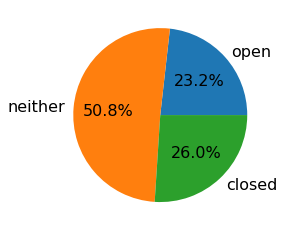

In [16]:
plt.pie([d['num_o'], d['num_n'], d['num_c']], labels=['open', 'neither', 'closed'], autopct='%1.1f%%')
plt.savefig('./elife_figs/1H.svg')

In [17]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 32})

In [18]:
pearsonr(o_o_all[:, 0], o_o_all[:, 1])

(0.5054894091149196, 8.870341685870969e-57)

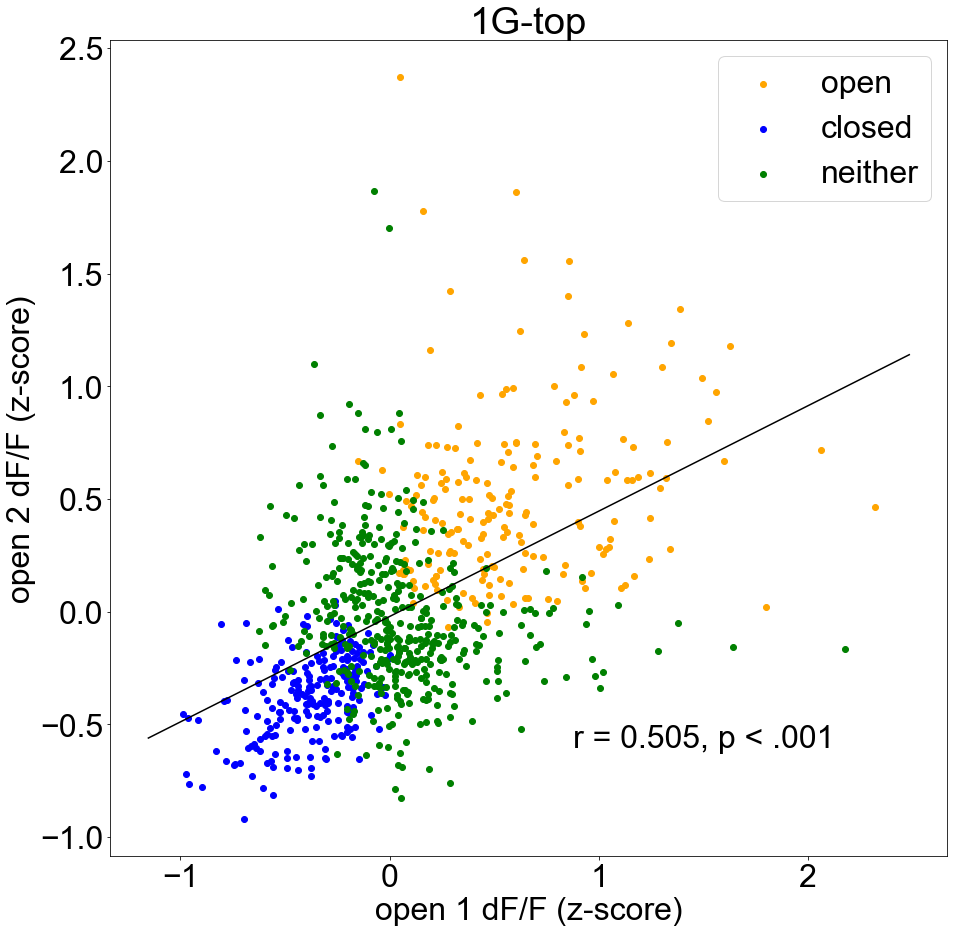

In [19]:
plt.figure(figsize=(15, 15))
plt.scatter(o_o_all[cta == 'o', 0], o_o_all[cta == 'o', 1], c = 'orange')
plt.scatter(o_o_all[cta == 'c', 0], o_o_all[cta == 'c', 1], c = 'b')
plt.scatter(o_o_all[cta == 'n', 0], o_o_all[cta == 'n', 1], c = 'g')

plt.xlabel('open 1 dF/F (z-score)')
plt.ylabel('open 2 dF/F (z-score)')

plt.legend(['open', 'closed', 'neither'])

xlim = np.array(plt.xlim())
lr = LR()
lr.fit(o_o_all[:, 0, np.newaxis], o_o_all[:, 1])
plt.plot(xlim, lr.predict(xlim[:, np.newaxis]), 'k')

plt.text(1.5, -0.6, 'r = {}, p < .001'.format(np.round(pearsonr(o_o_all[:, 0], o_o_all[:, 1])[0], 3)), ha = 'center')

plt.title('1G-top')
plt.savefig('./elife_figs/1G_top.svg')

In [20]:
pearsonr(o_c_all[:, 0], o_c_all[:, 1])

(-0.813018245559914, 4.859268589903849e-203)

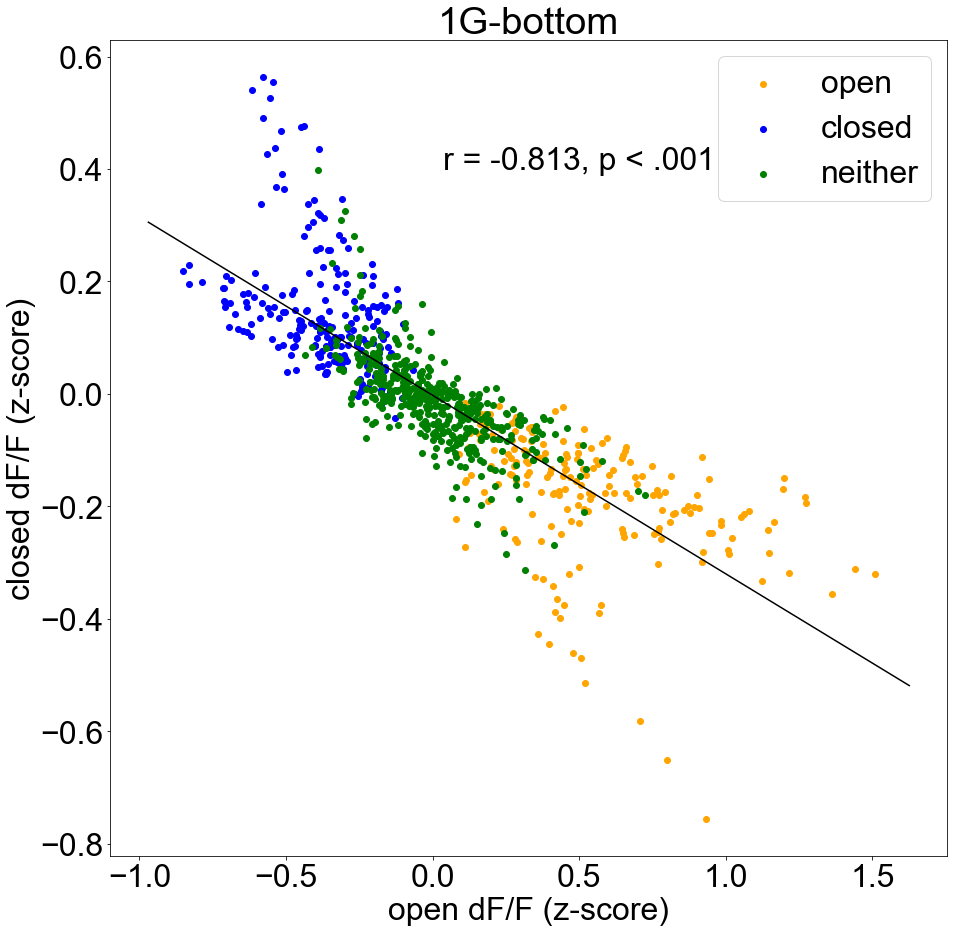

In [21]:
plt.figure(figsize=(15, 15))

plt.scatter(o_c_all[cta == 'o', 0], o_c_all[cta == 'o', 1], c = 'orange')
plt.scatter(o_c_all[cta == 'c', 0], o_c_all[cta == 'c', 1], c = 'b')
plt.scatter(o_c_all[cta == 'n', 0], o_c_all[cta == 'n', 1], c = 'g')

plt.xlabel('open dF/F (z-score)')
plt.ylabel('closed dF/F (z-score)')

plt.legend(['open', 'closed', 'neither'])

xlim = np.array(plt.xlim())
lr = LR()
lr.fit(o_c_all[:, 0, np.newaxis], o_c_all[:, 1])
plt.plot(xlim, lr.predict(xlim[:, np.newaxis]), 'k')

plt.text(0.5, 0.4, 'r = {}, p < .001'.format(np.round(pearsonr(o_c_all[:, 0], o_c_all[:, 1])[0], 3)), ha = 'center')

plt.title('1G-bottom')
plt.savefig('./elife_figs/1G_bottom.svg')